# dominating set

Set up calculations and store in EspressoDB

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
    plot_anneal_offset,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite

In [ ]:
# plot anneal offset ranges
#solver = "DW_2000Q_5"
#sampler = DWaveSampler(solver=solver)
#plot_anneal_offset(sampler)

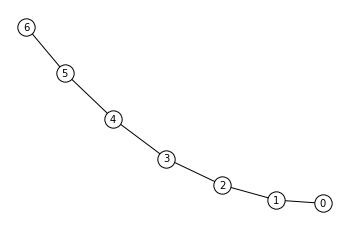

{'tag': 'NN(7)', 'total_vertices': 7, 'total_edges': 6, 'total_qubits': 19, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [4, 5], [5, 6], [2, 3], [3, 4]], 'adjacency_hash': '716f8c63effa926099861484e9a3f306'}
Greedy solution
 {0, 2, 4, 6}
Solving 1/1[Errno 2] No such file or directory: '../qlp/mds/embeddings/NN(7)_-0.1_0.12.yaml'


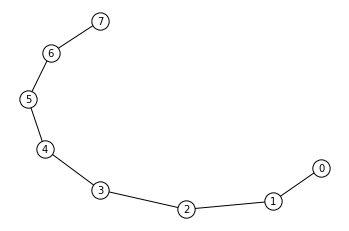

{'tag': 'NN(8)', 'total_vertices': 8, 'total_edges': 7, 'total_qubits': 22, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [6, 7], [4, 5], [5, 6], [2, 3], [3, 4]], 'adjacency_hash': '288514f57e775c5a3f5ee473dae9df3f'}
Greedy solution
 {0, 2, 4, 6}
Solving 1/1[Errno 2] No such file or directory: '../qlp/mds/embeddings/NN(8)_-0.1_0.12.yaml'


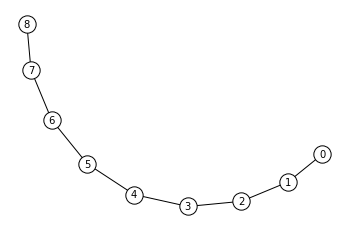

{'tag': 'NN(9)', 'total_vertices': 9, 'total_edges': 8, 'total_qubits': 25, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [7, 8], [6, 7], [4, 5], [5, 6], [2, 3], [3, 4]], 'adjacency_hash': '10d97ffe365cfd9ef831f319b2b9deb1'}
Greedy solution
 {0, 2, 4, 6, 8}
Solving 1/1[Errno 2] No such file or directory: '../qlp/mds/embeddings/NN(9)_-0.1_0.12.yaml'


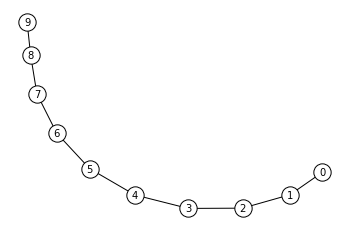

{'tag': 'NN(10)', 'total_vertices': 10, 'total_edges': 9, 'total_qubits': 28, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [7, 8], [6, 7], [4, 5], [5, 6], [8, 9], [2, 3], [3, 4]], 'adjacency_hash': '3f40e10fe865ba325d8d951eb04fa492'}
Greedy solution
 {0, 2, 4, 6, 8}
Solving 1/1[Errno 2] No such file or directory: '../qlp/mds/embeddings/NN(10)_-0.1_0.12.yaml'


TypeError: cannot unpack non-iterable NoneType object

In [6]:
# Define Adjacency matrix
# graph, tag = gt.generate_nn_graph(v)
# graph, tag = gt.generate_hamming_graph(d, v)
# graph, tag = gt.generate_bipartite_graph(p, q)
# graph, tag = gt.generate_newman_watts_strogatz_graph(v, n, p)
# graph, tag = gt.generate_corona_graph(k, n)

# Define anneal offset
# "constant": no offset
# "linear": linear with respect to |h|

#for offsetx in [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12]:

for nvertices in range(7, 11):
    """User defined inputs"""
    # Define graph
    #graph, tag = gt.generate_limited_corona_graph(2, 0)
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2
    # Embedding retries
    retries = 10000
    # Set functional form of anneal offset
    target_min = -0.1
    target_range = 0.12
    problem_min = -0.1
    problem_range = 0.12
    offsetcls = AnnealOffset("constant")
    # DWave parameters
    annealing_time = 600  # integer microseconds [1, 2000]
    answer_mode = "raw"  # histogram or raw
    auto_scale = True
    num_reads = 1000  # raw will dump out all results
    num_spin_reversal_transforms = 0
    readout_thermalization = 0  # default 0
    programming_thermalization = 1000  # default 1000
    # Iterate for more statistics
    iterations = 1
    insertdb = True

    """Start program"""
    # get qubo
    directed = False
    qubo = get_mds_qubo(
        graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
    )
    q_min = np.array(list(qubo.values())).min()

    # plot graph
    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph, qubo)
    print(graph_params)

    # greedy solution
    G = nx.Graph()
    G.add_edges_from(graph)
    print("Greedy solution\n", dominating_set(G))

    # convert to Ising
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))

    # Set chain strength
    chain_strength = maxJ * 2

    # DWave settings
    solver = "DW_2000Q_5"
    sampler = DWaveSampler(solver=solver)

    qpu_graph = sampler.edgelist
    qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}

    for idx in range(iterations):
        print(f"\rSolving {idx+1}/{iterations}", end="")
        embed, embedding, min_offset, max_offset = retry_embedding(
            sampler=sampler,
            qubo_dict=qubo_dict,
            qpu_graph=qpu_graph,
            graph_tag=tag,
            target_min=target_min,
            target_range=target_range,
            n_tries=retries,
        )
        anneal_offsets, exp_tag = find_offset(
            h=h,
            fcn=offsetcls.fcn,
            embedding=embedding,
            offset_min=problem_min,
            offset_range=problem_range,
        )
        dwave_config = {
            "annealing_time": annealing_time,  # integer microseconds [1, 2000]
            "answer_mode": answer_mode,  # histogram or raw
            "auto_scale": auto_scale,
            "num_reads": num_reads,  # raw will dump out all results
            "num_spin_reversal_transforms": num_spin_reversal_transforms,
            "readout_thermalization": readout_thermalization,  # default 0
            "programming_thermalization": programming_thermalization,  # default 1000
            "chain_strength": chain_strength,
            "anneal_offsets": anneal_offsets,
        }

        experiment_params = experiment_summary(
            machine=solver,
            settings=dwave_config,
            penalty=penalty,
            chain_strength=chain_strength,
            tag=exp_tag,
        )

        # Solve on DWave and push to database
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        if insertdb:
            result = insert_result(graph_params, experiment_params, data_params)
print("\nDONE")

In [ ]:
raw.sort_values("energy", ascending=True)